# Data Cleaning and Exploration

## Initialization

In [25]:
#Python Data Analysis imports
import pandas as pd
import numpy as np

#Visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#To grab stock data
import pandas_datareader.data as web
from pandas_datareader.yahoo.headers import DEFAULT_HEADERS
from datetime import datetime as dt
import datetime
import calendar
import yfinance as yf


# Caching
import requests_cache

In [40]:
stock_names = {'AAL': 'American Airlines Group Inc.', 'DAL': 'Delta Air Lines, Inc.', 'FB': 'Facebook', 'GOOGL': 'Google'}
stocks = ['AAL', 'DAL', 'FB', 'GOOGL']
AAL, DAL, FB, GOOGL = None, None, None, None
start = dt(2010, 1, 1)
end = dt(2019, 12, 31)

Making the same request repeatedly can use a lot of bandwidth, slow down your code and may result in your IP being banned.
We might not need to cache...

In [27]:
expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
session.headers = DEFAULT_HEADERS

In [41]:
def load_stocks(stocks, start, end):
    """
    Loads stock data from Yahoo Finance.
    """
    for stock in stocks:
        try:
            globals()[stock] = yf.download(tickers=stock, start=start, end=end ,interval="1mo", auto_adjust=True, prepost=False)
            globals()[stock].drop("Volume", axis=1, inplace=True)
        except Exception as  e:
            print('Error downloading: ' + stock, "error: ", e)
            return
    print('Data loaded successfully.')

In [42]:
load_stocks(stocks, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Data loaded successfully.


In [30]:
def Save_Stock_Data(path="data/", data=None):
    if data != None:
        data.to_csv(path + ".csv")
        return
    for stock in stocks:
        df_stock = globals()[stock]
        df_stock.to_csv(f"{path}{stock}.csv")
Save_Stock_Data()

## Data Cleaning

Features - Airline Stocks:

	- High -> Highest Price of the stock for that particular date.
	- Low -> Lowest Price of the stock for that particular date.
	- Open -> Opening Price of the stock.
	- Close -> Closing Price of the stock.
	- Volume -> Total amount of Trading Activity.
	- AdjClose -> Adjusted values factor in corporate actions such as dividends, stock splits, and new share issuance.

In [43]:
print(AAL.shape)
AAL.head()

(142, 4)


,Open,High,Low,Close
Date,,,,
2010-01-01,4.562868,5.618739,4.214054,5.005957
2010-02-01,5.119086,6.976287,5.043667,6.910295
2010-03-01,6.985713,7.702197,6.420068,6.929149
2010-04-01,6.948004,7.419374,5.910988,6.665182
2010-05-01,6.797166,8.456392,5.373627,8.324408


In [44]:
print(DAL.shape)
print(FB.shape)
print(GOOGL.shape)

(145, 4)
(91, 4)
(121, 4)


Check for missing values

In [46]:
def show_stock_missing_values():
    missing_values = pd.DataFrame(index=["High", "Low", "Open", "Close"], columns=stocks)
    for stock in stocks:
        missing_values[stock] = globals()[stock].isnull().sum()
    return missing_values

show_stock_missing_values()

,AAL,DAL,FB,GOOGL
High,22,25,0,1
Low,22,25,0,1
Open,22,25,0,1
Close,22,25,0,1


In [47]:
def Remove_Missing_values():
	for stock in stocks:
		globals()[stock].dropna(inplace=True)

Remove_Missing_values()
show_stock_missing_values()

,AAL,DAL,FB,GOOGL
High,0,0,0,0
Low,0,0,0,0
Open,0,0,0,0
Close,0,0,0,0


In [48]:
def stock_extract_dates():
    for stock in stocks:
        df_stock = globals()[stock]
        df_stock['Day'], df_stock['Month'], df_stock['Year'] = df_stock.index.day, df_stock.index.month, df_stock.index.year

stock_extract_dates()
AAL.head(2)

,Open,High,Low,Close,Day,Month,Year
Date,,,,,,,
2010-01-01,4.562868,5.618739,4.214054,5.005957,1,1,2010
2010-02-01,5.119086,6.976287,5.043667,6.910295,1,2,2010


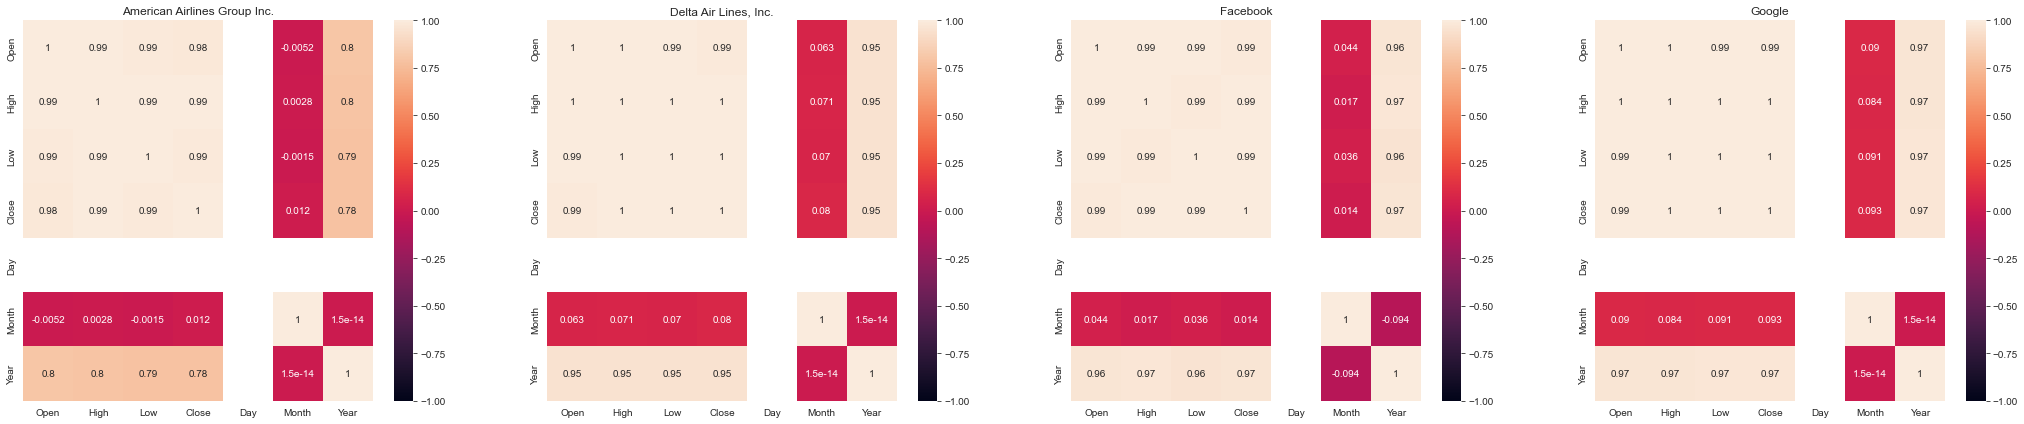

In [49]:
def stocks_corr():
    fig, ax = plt.subplots(1, len(stocks), figsize=(9*len(stocks), 7))
    for i, stock in enumerate(stocks):
        ax[i].set_title(stock_names[stock])
        sns.heatmap(globals()[stock].corr(), vmin=-1, vmax=1,  ax=ax[i], annot=True)

stocks_corr()

## Exploratory Data Analysis

In [51]:
def plot_feature_per_stock(features, years):
	fig, ax = plt.subplots(1, len(stocks), figsize=(7*len(stocks), 6))
	for i, stock in enumerate(stocks):
			df_stock = globals()[stock]
			df_stock = df_stock.loc[df_stock["Year"].isin(years)]

			ax[i].set_title(stock_names[stock] + " - " + ",".join(str(year) for year in years))
			df_stock.plot(y=features, ax=ax[i], label=[f"{stock} - {f}" for f in features])

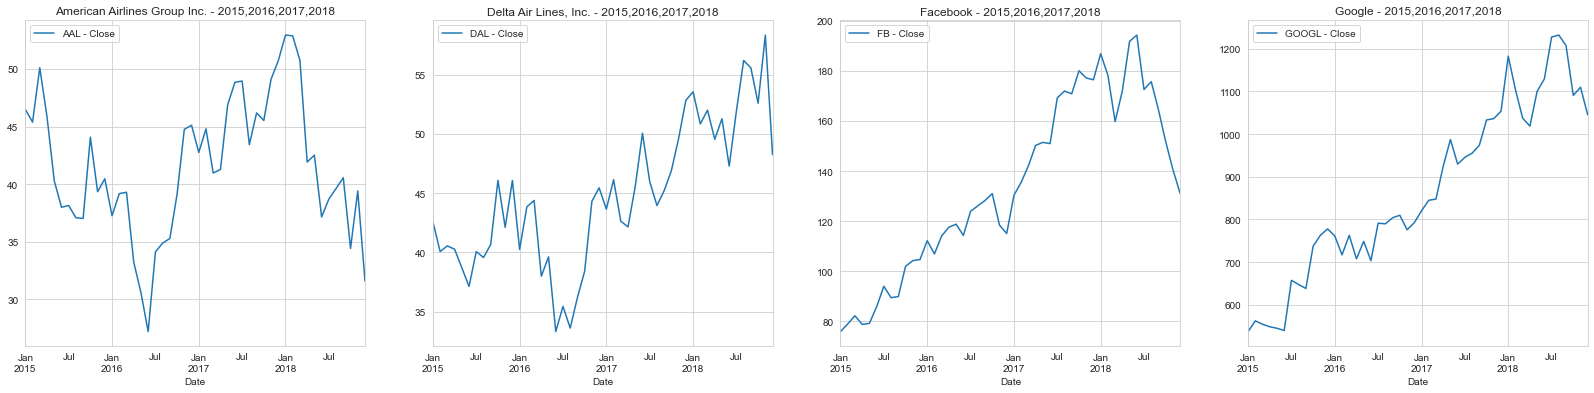

In [52]:
plot_feature_per_stock(["Close"], [2015, 2016, 2017, 2018])

ARIMA, assumes the data to be stationary.
Looking at the different stock prices, we can see that the stock prices are not stationary.
As we can see there are some seasonal patterns in the airline stocks, and we also see a strong trend in the stock prices of Facebook and Google.
We therefore assume the stock prices to be non-stationary.
We will perform some analysis to further prove our assumption.

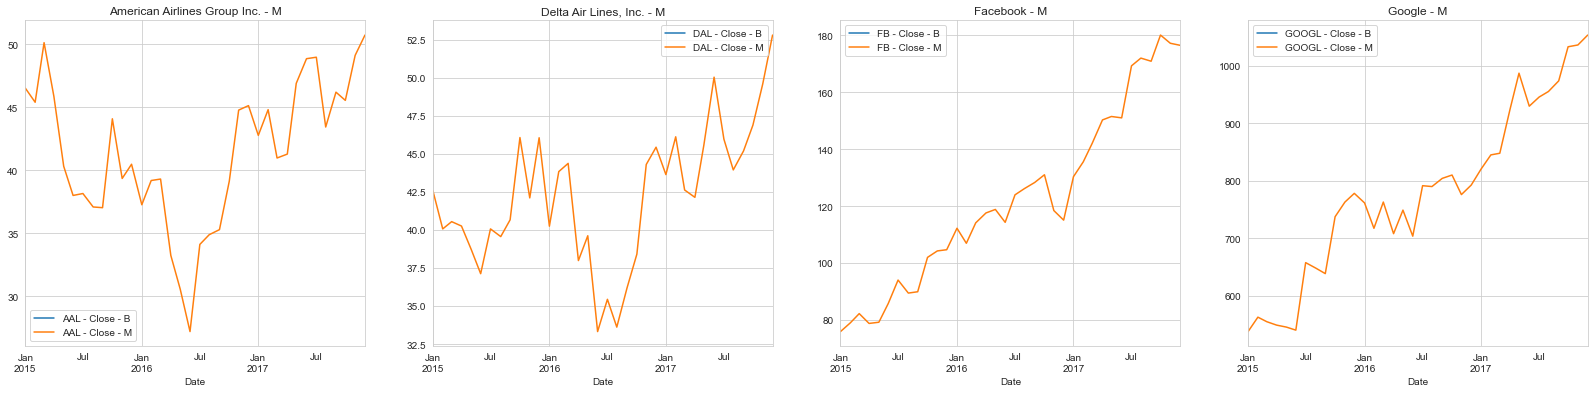

In [53]:
def plot_stock_resampled(features:list = ['Open'], years:list = [2015]):
    fig, ax = plt.subplots(1, len(stocks), figsize=(7*len(stocks), 6))
    resamples = ['B', 'M']
    for i, stock in enumerate(stocks):
        df_stock = globals()[stock]
        df_stock = df_stock.loc[df_stock["Year"].isin(years)]

        for resample in resamples:
            ax[i].set_title(f"{stock_names[stock]} - {resample}")
            df_stock.resample(resample).mean().plot(y=features, ax=ax[i], label=[f"{stock} - {f} - {resample}" for f in features])

        continue

plot_stock_resampled(features=['Close'], years=[2015, 2016, 2017])

### Seasonality and Trend - Analysis

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
def stock_seasonality_and_trends_decompose(feature='Open', method='classical', model='additive', freq='B', period=1, years=[2015, 2016], stocktypes='all'):
    stocks_selected = []

    if stocktypes == 'all':
        stocks_selected = stocks
    elif stocktypes == 'tech':
        stocks_selected = ['FB', 'GOOGL']
    elif stocktypes == 'airline':
        stocks_selected = ['AAL', 'DAL']

    print(stocks_selected)

    fig, ax = plt.subplots(4, len(stocks_selected), figsize=(25, 20))
    for i, stock in enumerate(stocks_selected):
        df_stock = globals()[stock]
        df_stock = df_stock.loc[df_stock["Year"].isin(years)]
        df_stock = df_stock.resample(freq).mean().fillna(method='ffill')
        # df_stock = df_stock.asfreq(freq).dropna()
        df_stock_decompose = None
        decompostion = []

        if method == 'classical':
            df_stock_decompose = seasonal_decompose(df_stock[feature], model=model, period=period)
        elif method == 'STL':
            df_stock_decompose = STL(df_stock[feature], seasonal=13, period=period).fit()
        
        if df_stock_decompose == None:
            print('Error decomposing: ' + stock)
            return

        
        ax[0, i].plot(df_stock[feature])
        ax[0, i].set_title(f"Observed - ({stock_names[stock]})")
        ax[0, i].tick_params(axis='x', labelrotation=45)

        ax[1, i].plot(df_stock_decompose.trend)
        ax[1, i].set_title(f"Trend - ({stock_names[stock]})")
        ax[1, i].tick_params(axis='x',labelrotation=45)

        ax[2, i].plot(df_stock_decompose.seasonal)
        ax[2, i].set_title(f"Seasonal - ({stock_names[stock]})")
        ax[2, i].tick_params(axis='x',labelrotation=45)

        resid_mu = df_stock_decompose.resid.mean()
        resid_dev = df_stock_decompose.resid.std()

        lower = resid_mu - 3*resid_dev
        upper = resid_mu + 3*resid_dev

        anomalies = df_stock[feature][(df_stock_decompose.resid < lower) | (df_stock_decompose.resid > upper)]


        ax[3, i].plot(df_stock_decompose.resid)
        ax[3, i].fill_between([dt(min(years),1,1), dt(max(years)+1,1,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
        ax[3, i].set_title(f"Residual - ({stock_names[stock]})")
        ax[3, i].tick_params(axis='x',labelrotation=45)


        # adjusting positions of the subplots
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
        
        decompostion.append((stock, df_stock_decompose, anomalies))


In [55]:
years = list(range(start.year, end.year))
periods = [year for year in AAL.index.year.value_counts()]
print(years, periods)
period = np.mean(periods).astype(int)
period

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018] [12, 12, 12, 12, 12, 12, 12, 12, 12, 12]


12

['FB', 'GOOGL']


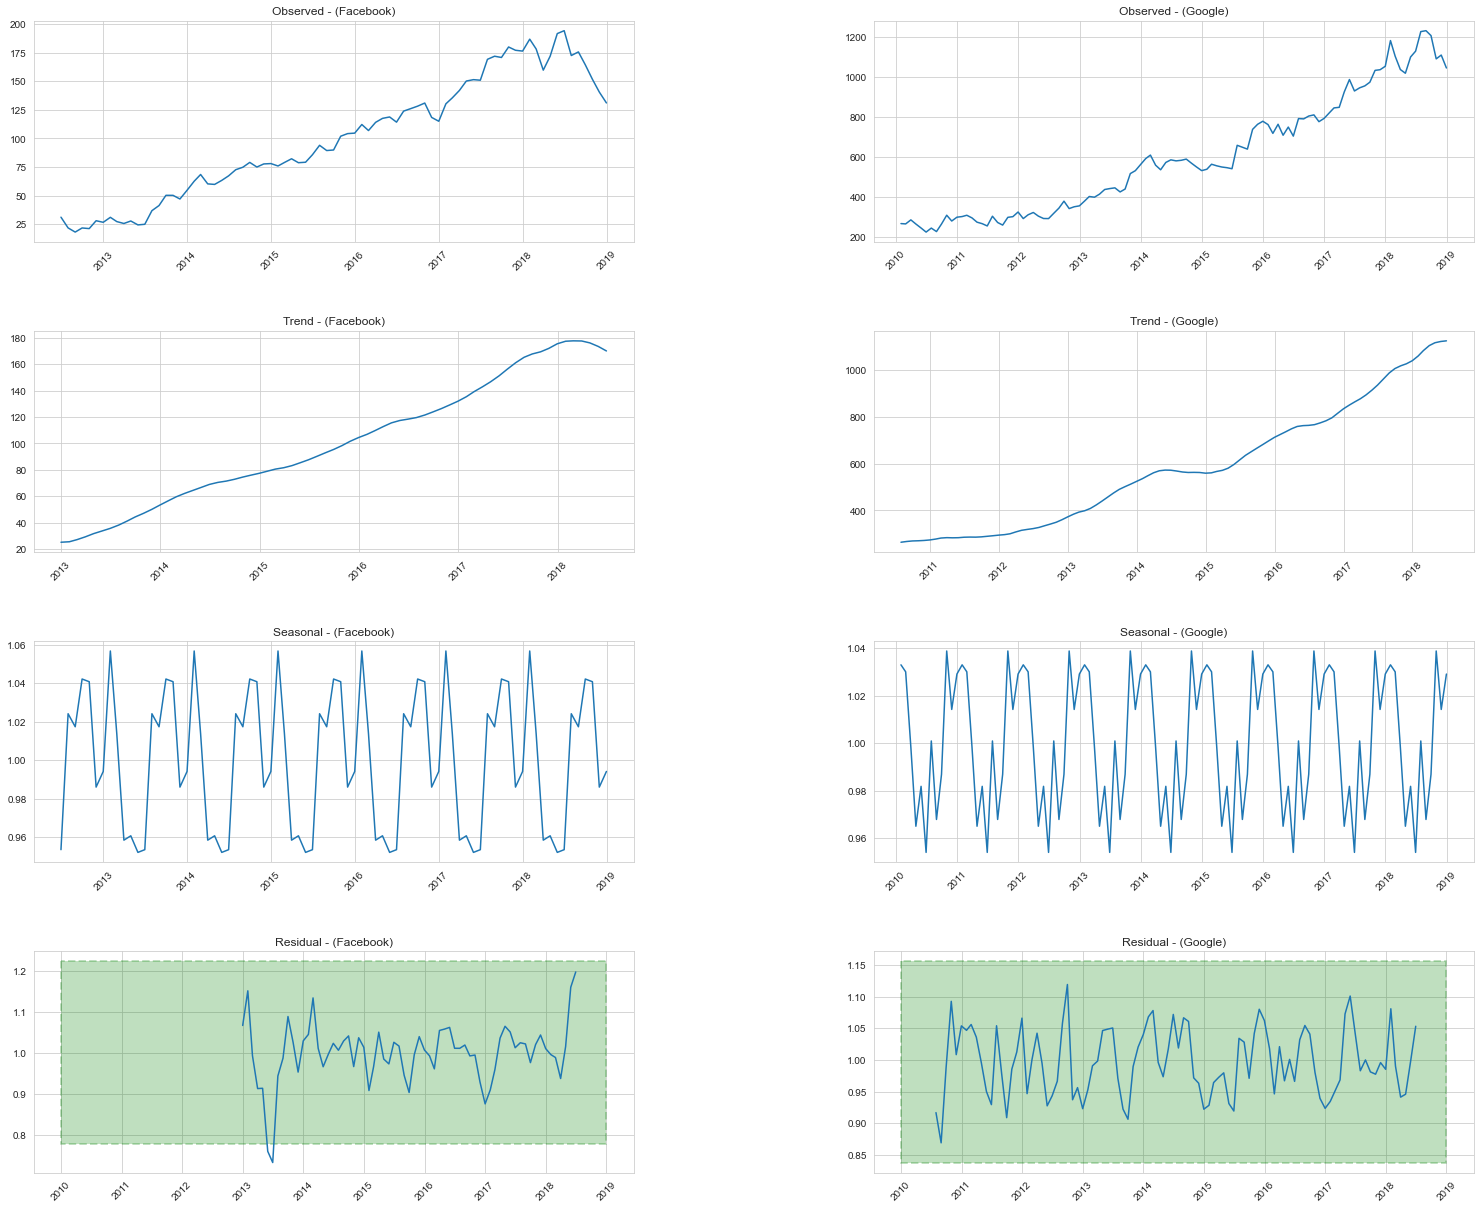

In [57]:
decompose_res_classical = stock_seasonality_and_trends_decompose("Close", model="multiplicative", method='classical', freq="M", period=period, years=years, stocktypes='tech')

As we see all of the stocks are not-stationary. This is because there are some seasonal patterns as well as a strong trend for every stock.
The seasonal decompose method uses classical time series decomposition techniques to decompose the time series into a seasonal component and a trend component.
This approach has some disadvantages,
	- it uses moving averages to estimate the trend-component, and thus some observations from the data are absent from the trend-cycle
	- it assumes that the seasonal component is constant over time. While this might be true for a short period of time, it becomes false as the time series progresses.
	For example the number of tourists has increased over the years, but the seasonal component is somewhat constant. 
	- It also tends to over-smooth the trend-cycle estimates.

Luckily there are other methods to decompose time series, which are much more robust in comparison to the classical decomposition methods.
One of these methods is STL decomposition.
This method is recommended to use when working with data that is not quartaly or monthly time series. 

['AAL', 'DAL', 'FB', 'GOOGL']


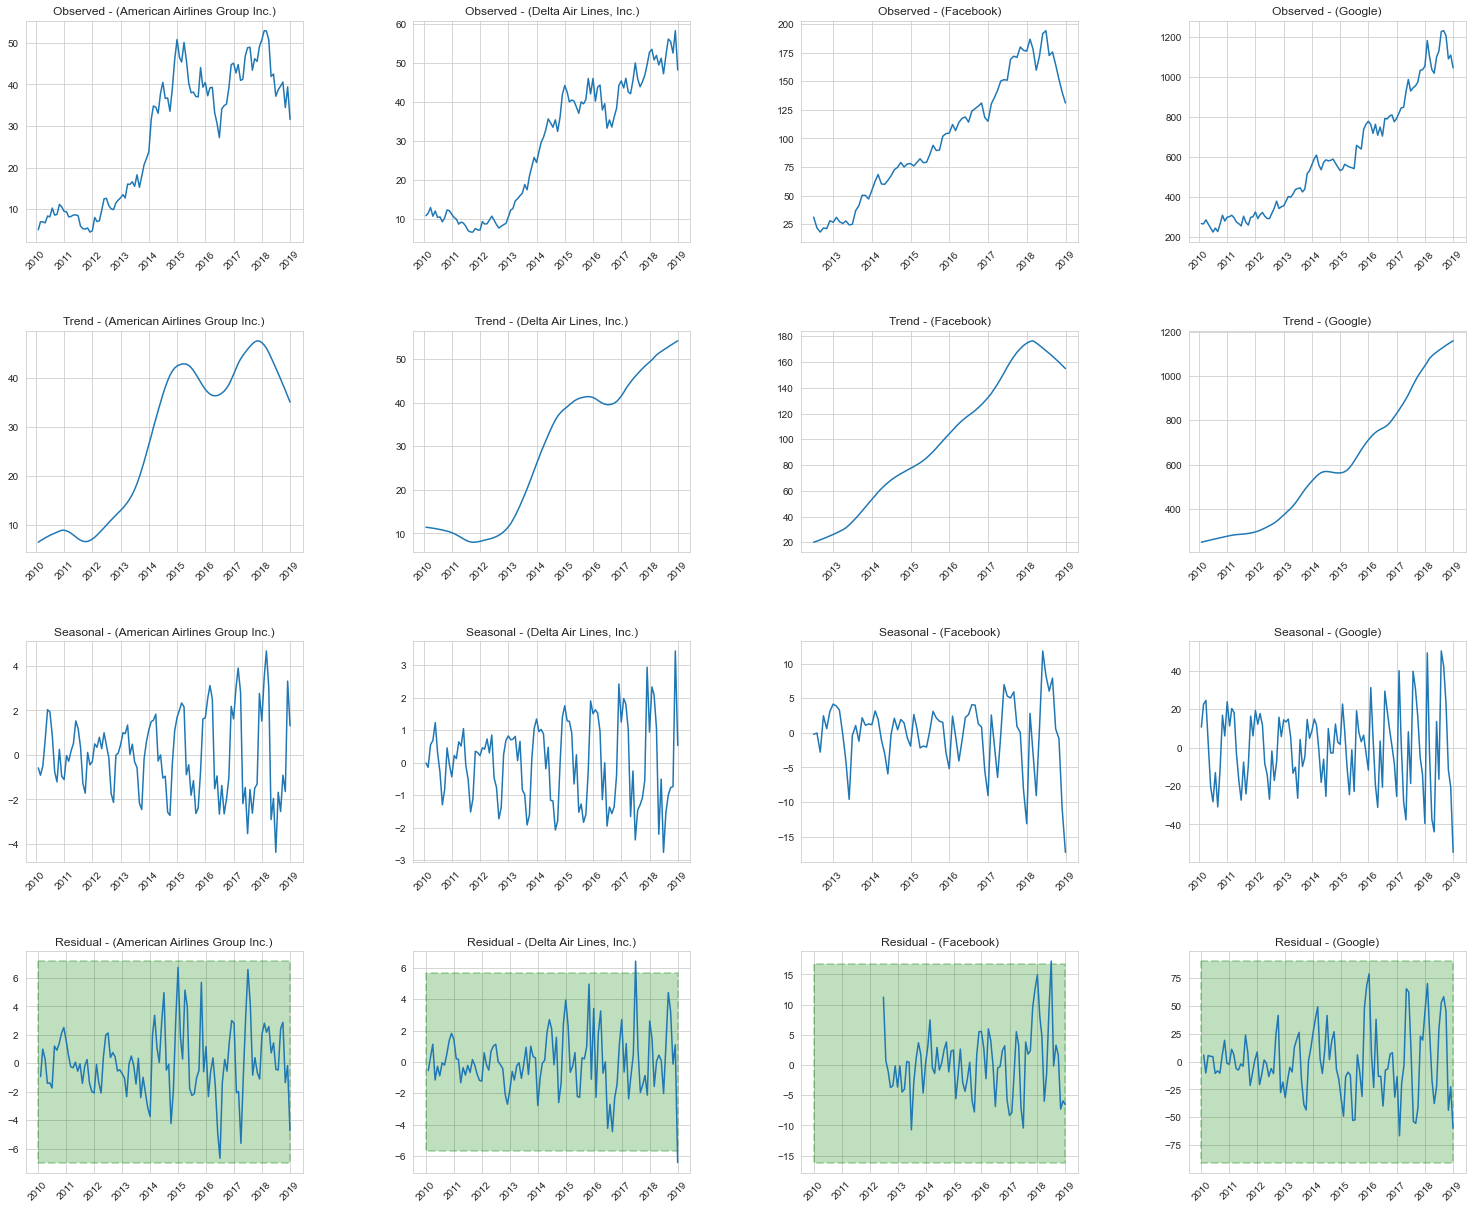

In [58]:
decompose_res_STL = stock_seasonality_and_trends_decompose("Close", model="additive", method='STL', freq="M", period=period, years=years)

Time series looks like its seasonal, and therefore we keep our assumtion that the time series is non-stationary.


we will check by performing (Augmented Dickey-Fuller) test

### Stationarity - Analysis

As mentioned a time series is stationary if statistical properties such as mean and remains constant over time,
and autocovariance does not depend on time.

ADF - Null Hypothesis: Not Stationary


,AAL-ADF,DAL-ADF,FB-ADF,GOOGL-ADF
Test,ADF,ADF,ADF,ADF
ADF,-1.484937,-0.424121,-1.543262,1.199853
p-value,0.540949,0.905993,0.512012,0.995985
C-1%,-3.492996,-3.493602,-3.520713,-3.500379
C-5%,-2.888955,-2.889217,-2.900925,-2.892152
C-10%,-2.581393,-2.581533,-2.587781,-2.5831
C-2.5%,-,-,-,-


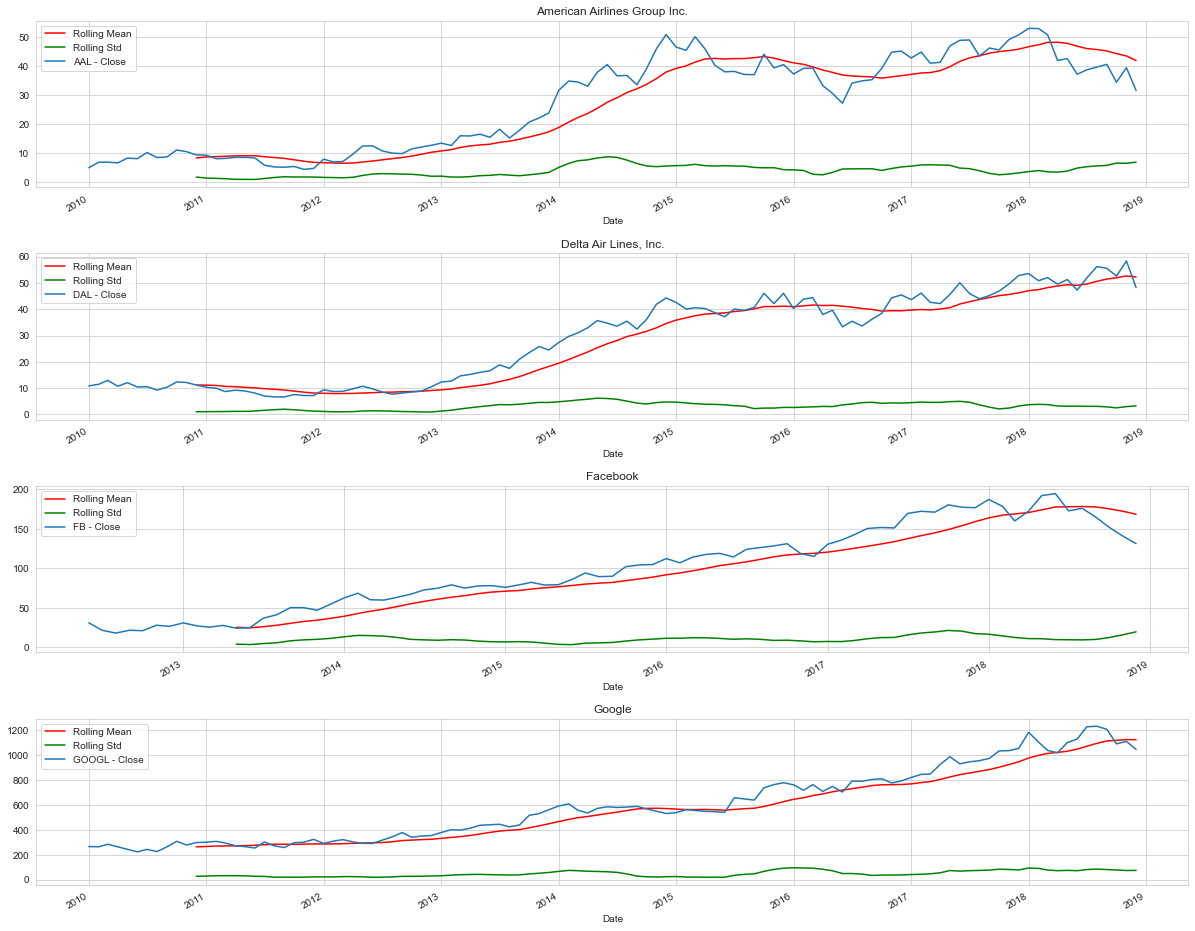

In [59]:
import warnings
from statsmodels.tsa.stattools import adfuller, kpss

def Get_Stationarity_Stats(feature = 'Close', period = 1, years=[2015, 2016], data=None):
    stats = pd.DataFrame(index=["Test", "ADF", "p-value", "C-1%", "C-5%", "C-10%", "C-2.5%"])
    print("ADF - Null Hypothesis: Not Stationary")

    fig, ax = plt.subplots(len(stocks), 1, figsize=(20, 15))
    for i, stock in enumerate(stocks):
        if data == None:
            df_stock = globals()[stock] 
        else:
            data[stock]
        df_stock = df_stock.loc[df_stock["Year"].isin(years)] if data == None else data[stock]

        rolling_mean = df_stock[feature].rolling(period).mean()
        rolling_std_dev = df_stock[feature].rolling(period).std()

        adf_test = adfuller(df_stock[feature])

        ax[i].set_title(stock_names[stock])
        ax[i].plot(rolling_mean, color='r', label='Rolling Mean')
        ax[i].plot(rolling_std_dev, color='g', label='Rolling Std')
        df_stock.plot(y=[feature], ax=ax[i], label=[f"{stock} - {feature}"])
        ax[i].legend(loc='best')


        stats[f"{stock}-ADF"] = ["ADF", adf_test[0], adf_test[1], adf_test[4]['1%'], adf_test[4]['5%'], adf_test[4]['10%'], "-"]

        # adjusting positions of the subplots
        plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    return stats

stationarity_stats = Get_Stationarity_Stats(period=period, years=years)
stationarity_stats

As we see the standard deviation of the stock prices varies a little bit over the years but is more or less constant. <br>
In contrary the mean is clearly increasing over the years, and so does the variance of the mean. ? TODO rewrite <br>

We also see, from the test statistic, that both the airline stocks and tech stocks are non-stationary, but the airline stocks have a higher degree of non-stationarity.
All test statistics are greater than the critical values for each stock. <br>
The p-value for all of stocks are greater than 0.05, therefore we feil to reject the null hypothesis, and hence all of the stocks are non-stationary.

#### Making the stocks stationary

,AAL-ADF,DAL-ADF,FB-ADF,GOOGL-ADF
Test,ADF,ADF,ADF,ADF
ADF,-10.221015,-12.274809,-4.068529,-3.221368
p-value,0.0,0.0,0.001091,0.018781
C-1%,-3.493602,-3.493602,-3.520713,-3.500379
C-5%,-2.889217,-2.889217,-2.900925,-2.892152
C-10%,-2.581533,-2.581533,-2.587781,-2.5831
C-2.5%,-,-,-,-


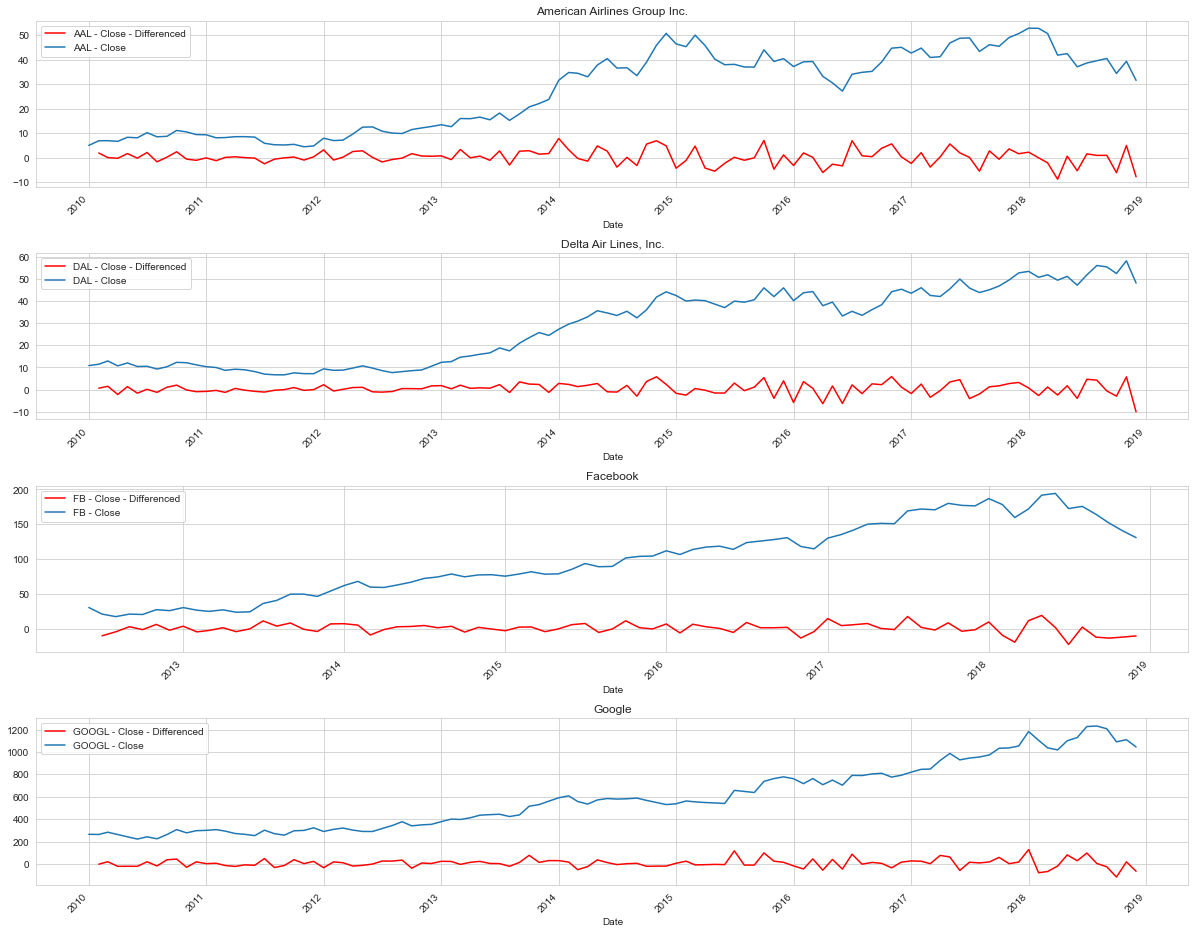

In [62]:
def Differencing(feature, period=12, years=[2015, 2016]):
	stats = pd.DataFrame(index=["Test", "ADF", "p-value", "C-1%", "C-5%", "C-10%", "C-2.5%"])

	fig, ax = plt.subplots(len(stocks), 1, figsize=(20, 15))
	for i, stock in enumerate(stocks):
		df_stock = globals()[stock] 
		df_stock = df_stock.loc[df_stock["Year"].isin(years)]

		diff = df_stock[feature] - df_stock[feature].shift(period)
		diff.dropna(inplace=True)

		adf_test = adfuller(diff)
		stats[f"{stock}-ADF"] = ["ADF", adf_test[0], adf_test[1], adf_test[4]['1%'], adf_test[4]['5%'], adf_test[4]['10%'], "-"]

		ax[i].set_title(stock_names[stock])
		ax[i].plot(diff, color='r', label=f'{stock} - {feature} - Differenced')
		df_stock.plot(y=[feature], ax=ax[i], label=[f"{stock} - {feature}"])
		ax[i].tick_params(axis='x',labelrotation=45)
		ax[i].legend(loc='best')

		# adjusting positions of the subplots
		plt.subplots_adjust(left=0.1,
								bottom=0.1, 
								right=0.9, 
								top=0.9, 
								wspace=0.4, 
								hspace=0.4)

	return stats

Differencing_stats = Differencing(feature='Close', period=1, years=years)
Differencing_stats